In [1]:
%reload_ext autoreload
%autoreload 2

In [4]:
from typing import *
import math
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange
from timm.models.layers import DropPath
from timm.models.layers.helpers import to_2tuple
import functools as ft
import numbers
from tqdm import tqdm
import matplotlib.pyplot as plt

from timm.models.energy_transformer import ClassicalHopfield, HopfieldMLP, KQEnergyBlock, KQAlignedAttention, EnergyLayerNorm

/gpfs/u/home/DAMT/DAMThvrb/scratch/miniconda3-ppc/envs/timm/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Test energy transformer

In [5]:
mod = HopfieldMLP(768, 4*768, bias=False).to(0)
x = torch.randn((32, 768), device=0)

In [6]:
depth = 100
alpha = 0.1
norm = nn.LayerNorm(x.shape[-1], elementwise_affine=False)
xx = x
energies = [mod.energy(xx)]
with torch.no_grad():
    for i in range(depth):
        g = norm(xx)
        xx = x - mod(g)
        energies.append(mod.energy(xx))
energies = torch.stack(energies)

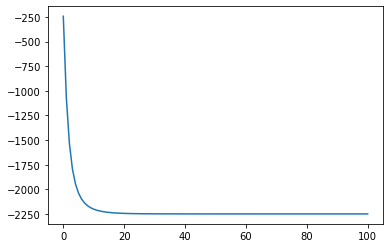

In [7]:
plt.plot(energies.detach().cpu().numpy()[:,0])

In [8]:
#hide
bs, N, dim = 32,196,768
nheads=8
attn = KQAlignedAttention(dim, nheads, False, head_dim=64).to(0)
toks = torch.randn(bs,N,dim).to(0)
toks_out = attn(toks)

In [9]:
[k for k,v in attn.named_parameters()]

['betas', 'q_proj.weight', 'k_proj.weight']

In [10]:
# Naive check: am I descending energy?
alpha = 1
depth = 100
x = toks
norm = nn.LayerNorm(x.shape[-1], elementwise_affine=False, device=x.device)
energies = [attn.energy(norm(x))]
with torch.no_grad():
    for i in tqdm(range(depth)):
        g = norm(x)
        x = x - alpha*attn(g)
        energies.append(attn.energy(norm(x)))
    
energies=torch.stack(energies)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 158.52it/s]


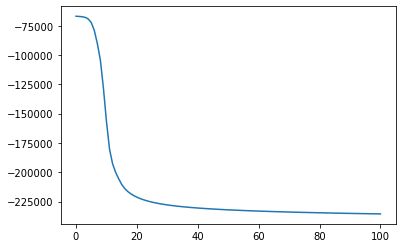

In [11]:
plt.plot(energies[:,0].detach().cpu().numpy())

In [12]:
class EnergyLayerNorm(nn.Module):
    def __init__(self, normalized_shape: Union[int, List[int], torch.Size], eps: float=1e-5, train_scale=True, train_bias=True, device=None, dtype=None):
        """An energy plausible version of layernorm, assumes the dimension of interest is dim=-1"""
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.train_scale = train_scale
        self.train_bias = train_bias
        self.normalized_shape=normalized_shape
        
        if self.train_scale:
            self.weight = nn.Parameter(torch.empty(1, **factory_kwargs))
        else:
            self.register_parameter('weight', None)
            
        if self.train_bias:
            self.bias = nn.Parameter(torch.empty(self.normalized_shape, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        
        self.reset_parameters()
        
    def reset_parameters(self) -> None:
        if self.train_scale:
            nn.init.ones_(self.weight)
        if self.train_bias:
            nn.init.zeros_(self.bias)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        weight = self.weight if self.train_scale else 1.
        bias = self.bias if self.train_bias else 0.
                
        std, mean = torch.std_mean(x, -1, keepdim=True)
        return weight * (x - mean) / std + bias 
    
class KQEnergyBlock(nn.Module):
    def __init__(
            self, dim, num_heads, mlp_ratio=4., qkv_bias=False, init_values=None, act_layer=nn.ReLU):#, norm_layer=EnergyLayerNorm):
        super().__init__()
        self.attn = KQAlignedAttention(dim, num_heads=num_heads, qkv_bias=qkv_bias)
        self.chn = HopfieldMLP(in_features=dim, hidden_features=int(dim * mlp_ratio), act_layer=act_layer)

    def forward(self, g, alpha=0.1):
        return self.attn(g) + self.chn(g)

    def energy(self, x):
        return self.attn.energy(x) + self.chn.energy(x).sum(-1)

In [13]:
block = KQEnergyBlock(768, 8).to(toks.device)

In [14]:
# Naive check: am I descending energy?
alpha = 0.1
depth = 1000
n_energies = 1000
energy_every = depth // n_energies
x = toks[:1]
norm = EnergyLayerNorm(x.shape[-1], device=x.device)
energies = torch.empty(n_energies+1)
energies[0] = block.energy(norm(x))[0]
with torch.no_grad():
    for i in tqdm(range(depth)):
        g = norm(x)
        x = x - alpha*block(g)
        if ((i+1)%energy_every) == 0:
            j = (i+1) // energy_every
            energies[j] = block.energy(norm(x))[0]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 477.11it/s]


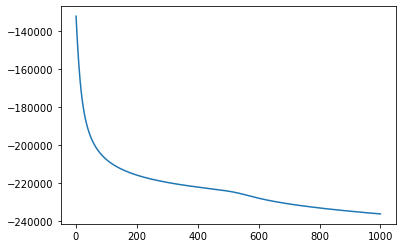

In [15]:
plt.plot(energies.detach().cpu().numpy())

In [16]:
from timm.models.helpers import checkpoint_seq

In [17]:
from timm.models.energy_transformer import EnergyVisionTransformer

In [18]:
bs, C,H,W = 7, 3, 224, 224
x = torch.randn((bs,C,H,W)).to(0)
model=EnergyVisionTransformer(embed_dim=768, num_heads=8, qkv_bias=False, depth=1).to(0)

In [19]:
y = model.forward_features(x)

In [20]:
import timm

In [70]:
model = timm.models.create_model("et_base_patch16_224", qkv_bias=True).to(0)

In [71]:
[k for k,v in model.named_parameters()]

['cls_token',
 'pos_embed',
 'patch_embed.proj.weight',
 'patch_embed.proj.bias',
 'block.attn.betas',
 'block.attn.q_proj.weight',
 'block.attn.q_proj.bias',
 'block.attn.k_proj.weight',
 'block.attn.k_proj.bias',
 'block.chn.mlp.weight',
 'norm.weight',
 'norm.bias',
 'fc_norm.weight',
 'fc_norm.bias',
 'head.weight',
 'head.bias']

In [60]:
y = model.forward_features(x, 0.1)

In [61]:
z = model.forward_head(y)

# Pytorch lightning from TIMM model

In [68]:
import pytorch_lightning as pl
import torch
from torch import nn
import torch.nn.functional as F

In [72]:
from timm.scheduler import StepLRScheduler
class TimmStepLRScheduler(torch.optim.lr_scheduler.LambdaLR):
    def __init__(self, optim, **kwargs):
        self.init_lr = optim.param_groups[0]["lr"]
        self.timmsteplr = StepLRScheduler(optim, **kwargs)
        super().__init__(optim, self)

    def __call__(self, epoch):
        desired_lr = self.timmsteplr.get_epoch_values(epoch)[0]
        mult = desired_lr / self.init_lr
        return mult

In [85]:
import argparse
import functools as ft
import pytorch_lightning as pl
# from krotorch.utils import get_cosine_schedule_with_warmup
# from krotorch.vitam.data import show_tensor
import timm
from timm.data import create_dataset, create_loader, resolve_data_config, Mixup, FastCollateMixup, AugMixDataset
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from timm.utils import *
from timm.loss import *
from timm.optim import create_optimizer_v2, optimizer_kwargs
from timm.scheduler import create_scheduler
from timm.utils import ApexScaler, NativeScaler

config_parser = parser = argparse.ArgumentParser(description='Training Config', add_help=False)
parser.add_argument('-c', '--config', default='', type=str, metavar='FILE',
                    help='YAML config file specifying default arguments')


parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')

# Dataset parameters
parser.add_argument('data_dir', metavar='DIR',
                    help='path to dataset')
parser.add_argument('--dataset', '-d', metavar='NAME', default='',
                    help='dataset type (default: ImageFolder/ImageTar if empty)')
parser.add_argument('--train-split', metavar='NAME', default='train',
                    help='dataset train split (default: train)')
parser.add_argument('--val-split', metavar='NAME', default='validation',
                    help='dataset validation split (default: validation)')
parser.add_argument('--dataset-download', action='store_true', default=False,
                    help='Allow download of dataset for torch/ and tfds/ datasets that support it.')
parser.add_argument('--class-map', default='', type=str, metavar='FILENAME',
                    help='path to class to idx mapping file (default: "")')

# Model parameters
parser.add_argument('--model', default='resnet50', type=str, metavar='MODEL',
                    help='Name of model to train (default: "resnet50"')
parser.add_argument('--pretrained', action='store_true', default=False,
                    help='Start with pretrained version of specified network (if avail)')
parser.add_argument('--initial-checkpoint', default='', type=str, metavar='PATH',
                    help='Initialize model from this checkpoint (default: none)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='Resume full model and optimizer state from checkpoint (default: none)')
parser.add_argument('--no-resume-opt', action='store_true', default=False,
                    help='prevent resume of optimizer state when resuming model')
parser.add_argument('--num-classes', type=int, default=None, metavar='N',
                    help='number of label classes (Model default if None)')
parser.add_argument('--gp', default=None, type=str, metavar='POOL',
                    help='Global pool type, one of (fast, avg, max, avgmax, avgmaxc). Model default if None.')
parser.add_argument('--img-size', type=int, default=None, metavar='N',
                    help='Image patch size (default: None => model default)')
parser.add_argument('--input-size', default=None, nargs=3, type=int,
                    metavar='N N N', help='Input all image dimensions (d h w, e.g. --input-size 3 224 224), uses model default if empty')
parser.add_argument('--crop-pct', default=None, type=float,
                    metavar='N', help='Input image center crop percent (for validation only)')
parser.add_argument('--mean', type=float, nargs='+', default=None, metavar='MEAN',
                    help='Override mean pixel value of dataset')
parser.add_argument('--std', type=float, nargs='+', default=None, metavar='STD',
                    help='Override std deviation of dataset')
parser.add_argument('--interpolation', default='', type=str, metavar='NAME',
                    help='Image resize interpolation type (overrides model)')
parser.add_argument('-b', '--batch-size', type=int, default=128, metavar='N',
                    help='Input batch size for training (default: 128)')
parser.add_argument('-vb', '--validation-batch-size', type=int, default=None, metavar='N',
                    help='Validation batch size override (default: None)')
parser.add_argument('--channels-last', action='store_true', default=False,
                    help='Use channels_last memory layout')
parser.add_argument('--torchscript', dest='torchscript', action='store_true',
                    help='torch.jit.script the full model')
parser.add_argument('--fuser', default='', type=str,
                    help="Select jit fuser. One of ('', 'te', 'old', 'nvfuser')")
parser.add_argument('--grad-checkpointing', action='store_true', default=False,
                    help='Enable gradient checkpointing through model blocks/stages')

# Optimizer parameters
parser.add_argument('--opt', default='sgd', type=str, metavar='OPTIMIZER',
                    help='Optimizer (default: "sgd"')
parser.add_argument('--opt-eps', default=None, type=float, metavar='EPSILON',
                    help='Optimizer Epsilon (default: None, use opt default)')
parser.add_argument('--opt-betas', default=None, type=float, nargs='+', metavar='BETA',
                    help='Optimizer Betas (default: None, use opt default)')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='Optimizer momentum (default: 0.9)')
parser.add_argument('--weight-decay', type=float, default=2e-5,
                    help='weight decay (default: 2e-5)')
parser.add_argument('--clip-grad', type=float, default=None, metavar='NORM',
                    help='Clip gradient norm (default: None, no clipping)')
parser.add_argument('--clip-mode', type=str, default='norm',
                    help='Gradient clipping mode. One of ("norm", "value", "agc")')
parser.add_argument('--layer-decay', type=float, default=None,
                    help='layer-wise learning rate decay (default: None)')

# Learning rate schedule parameters
parser.add_argument('--sched', default='cosine', type=str, metavar='SCHEDULER',
                    help='LR scheduler (default: "step"')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                    help='learning rate (default: 0.05)')
parser.add_argument('--lr-noise', type=float, nargs='+', default=None, metavar='pct, pct',
                    help='learning rate noise on/off epoch percentages')
parser.add_argument('--lr-noise-pct', type=float, default=0.67, metavar='PERCENT',
                    help='learning rate noise limit percent (default: 0.67)')
parser.add_argument('--lr-noise-std', type=float, default=1.0, metavar='STDDEV',
                    help='learning rate noise std-dev (default: 1.0)')
parser.add_argument('--lr-cycle-mul', type=float, default=1.0, metavar='MULT',
                    help='learning rate cycle len multiplier (default: 1.0)')
parser.add_argument('--lr-cycle-decay', type=float, default=0.5, metavar='MULT',
                    help='amount to decay each learning rate cycle (default: 0.5)')
parser.add_argument('--lr-cycle-limit', type=int, default=1, metavar='N',
                    help='learning rate cycle limit, cycles enabled if > 1')
parser.add_argument('--lr-k-decay', type=float, default=1.0,
                    help='learning rate k-decay for cosine/poly (default: 1.0)')
parser.add_argument('--warmup-lr', type=float, default=0.0001, metavar='LR',
                    help='warmup learning rate (default: 0.0001)')
parser.add_argument('--min-lr', type=float, default=1e-6, metavar='LR',
                    help='lower lr bound for cyclic schedulers that hit 0 (1e-5)')
parser.add_argument('--epochs', type=int, default=300, metavar='N',
                    help='number of epochs to train (default: 300)')
parser.add_argument('--epoch-repeats', type=float, default=0., metavar='N',
                    help='epoch repeat multiplier (number of times to repeat dataset epoch per train epoch).')
parser.add_argument('--start-epoch', default=None, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--decay-milestones', default=[30, 60], type=int, nargs='+', metavar="MILESTONES",
                    help='list of decay epoch indices for multistep lr. must be increasing')
parser.add_argument('--decay-epochs', type=float, default=100, metavar='N',
                    help='epoch interval to decay LR')
parser.add_argument('--warmup-epochs', type=int, default=3, metavar='N',
                    help='epochs to warmup LR, if scheduler supports')
parser.add_argument('--cooldown-epochs', type=int, default=10, metavar='N',
                    help='epochs to cooldown LR at min_lr, after cyclic schedule ends')
parser.add_argument('--patience-epochs', type=int, default=10, metavar='N',
                    help='patience epochs for Plateau LR scheduler (default: 10')
parser.add_argument('--decay-rate', '--dr', type=float, default=0.1, metavar='RATE',
                    help='LR decay rate (default: 0.1)')

# Augmentation & regularization parameters
parser.add_argument('--no-aug', action='store_true', default=False,
                    help='Disable all training augmentation, override other train aug args')
parser.add_argument('--scale', type=float, nargs='+', default=[0.08, 1.0], metavar='PCT',
                    help='Random resize scale (default: 0.08 1.0)')
parser.add_argument('--ratio', type=float, nargs='+', default=[3./4., 4./3.], metavar='RATIO',
                    help='Random resize aspect ratio (default: 0.75 1.33)')
parser.add_argument('--hflip', type=float, default=0.5,
                    help='Horizontal flip training aug probability')
parser.add_argument('--vflip', type=float, default=0.,
                    help='Vertical flip training aug probability')
parser.add_argument('--color-jitter', type=float, default=0.4, metavar='PCT',
                    help='Color jitter factor (default: 0.4)')
parser.add_argument('--aa', type=str, default=None, metavar='NAME',
                    help='Use AutoAugment policy. "v0" or "original". (default: None)'),
parser.add_argument('--aug-repeats', type=float, default=0,
                    help='Number of augmentation repetitions (distributed training only) (default: 0)')
parser.add_argument('--aug-splits', type=int, default=0,
                    help='Number of augmentation splits (default: 0, valid: 0 or >=2)')
parser.add_argument('--jsd-loss', action='store_true', default=False,
                    help='Enable Jensen-Shannon Divergence + CE loss. Use with `--aug-splits`.')
parser.add_argument('--bce-loss', action='store_true', default=False,
                    help='Enable BCE loss w/ Mixup/CutMix use.')
parser.add_argument('--bce-target-thresh', type=float, default=None,
                    help='Threshold for binarizing softened BCE targets (default: None, disabled)')
parser.add_argument('--reprob', type=float, default=0., metavar='PCT',
                    help='Random erase prob (default: 0.)')
parser.add_argument('--remode', type=str, default='pixel',
                    help='Random erase mode (default: "pixel")')
parser.add_argument('--recount', type=int, default=1,
                    help='Random erase count (default: 1)')
parser.add_argument('--resplit', action='store_true', default=False,
                    help='Do not random erase first (clean) augmentation split')
parser.add_argument('--mixup', type=float, default=0.0,
                    help='mixup alpha, mixup enabled if > 0. (default: 0.)')
parser.add_argument('--cutmix', type=float, default=0.0,
                    help='cutmix alpha, cutmix enabled if > 0. (default: 0.)')
parser.add_argument('--cutmix-minmax', type=float, nargs='+', default=None,
                    help='cutmix min/max ratio, overrides alpha and enables cutmix if set (default: None)')
parser.add_argument('--mixup-prob', type=float, default=1.0,
                    help='Probability of performing mixup or cutmix when either/both is enabled')
parser.add_argument('--mixup-switch-prob', type=float, default=0.5,
                    help='Probability of switching to cutmix when both mixup and cutmix enabled')
parser.add_argument('--mixup-mode', type=str, default='batch',
                    help='How to apply mixup/cutmix params. Per "batch", "pair", or "elem"')
parser.add_argument('--mixup-off-epoch', default=0, type=int, metavar='N',
                    help='Turn off mixup after this epoch, disabled if 0 (default: 0)')
parser.add_argument('--smoothing', type=float, default=0.1,
                    help='Label smoothing (default: 0.1)')
parser.add_argument('--train-interpolation', type=str, default='random',
                    help='Training interpolation (random, bilinear, bicubic default: "random")')
parser.add_argument('--drop', type=float, default=0.0, metavar='PCT',
                    help='Dropout rate (default: 0.)')
parser.add_argument('--drop-connect', type=float, default=None, metavar='PCT',
                    help='Drop connect rate, DEPRECATED, use drop-path (default: None)')
parser.add_argument('--drop-path', type=float, default=None, metavar='PCT',
                    help='Drop path rate (default: None)')
parser.add_argument('--drop-block', type=float, default=None, metavar='PCT',
                    help='Drop block rate (default: None)')

# Batch norm parameters (only works with gen_efficientnet based models currently)
parser.add_argument('--bn-momentum', type=float, default=None,
                    help='BatchNorm momentum override (if not None)')
parser.add_argument('--bn-eps', type=float, default=None,
                    help='BatchNorm epsilon override (if not None)')
parser.add_argument('--sync-bn', action='store_true',
                    help='Enable NVIDIA Apex or Torch synchronized BatchNorm.')
parser.add_argument('--dist-bn', type=str, default='reduce',
                    help='Distribute BatchNorm stats between nodes after each epoch ("broadcast", "reduce", or "")')
parser.add_argument('--split-bn', action='store_true',
                    help='Enable separate BN layers per augmentation split.')

# Model Exponential Moving Average
parser.add_argument('--model-ema', action='store_true', default=False,
                    help='Enable tracking moving average of model weights')
parser.add_argument('--model-ema-force-cpu', action='store_true', default=False,
                    help='Force ema to be tracked on CPU, rank=0 node only. Disables EMA validation.')
parser.add_argument('--model-ema-decay', type=float, default=0.9998,
                    help='decay factor for model weights moving average (default: 0.9998)')

# Misc
parser.add_argument('--seed', type=int, default=42, metavar='S',
                    help='random seed (default: 42)')
parser.add_argument('--worker-seeding', type=str, default='all',
                    help='worker seed mode (default: all)')
parser.add_argument('--log-interval', type=int, default=50, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--recovery-interval', type=int, default=0, metavar='N',
                    help='how many batches to wait before writing recovery checkpoint')
parser.add_argument('--checkpoint-hist', type=int, default=10, metavar='N',
                    help='number of checkpoints to keep (default: 10)')
parser.add_argument('-j', '--workers', type=int, default=4, metavar='N',
                    help='how many training processes to use (default: 4)')
parser.add_argument('--save-images', action='store_true', default=False,
                    help='save images of input bathes every log interval for debugging')
parser.add_argument('--amp', action='store_true', default=False,
                    help='use NVIDIA Apex AMP or Native AMP for mixed precision training')
parser.add_argument('--apex-amp', action='store_true', default=False,
                    help='Use NVIDIA Apex AMP mixed precision')
parser.add_argument('--native-amp', action='store_true', default=False,
                    help='Use Native Torch AMP mixed precision')
parser.add_argument('--no-ddp-bb', action='store_true', default=False,
                    help='Force broadcast buffers for native DDP to off.')
parser.add_argument('--pin-mem', action='store_true', default=False,
                    help='Pin CPU memory in DataLoader for more efficient (sometimes) transfer to GPU.')
parser.add_argument('--no-prefetcher', action='store_true', default=False,
                    help='disable fast prefetcher')
parser.add_argument('--output', default='', type=str, metavar='PATH',
                    help='path to output folder (default: none, current dir)')
parser.add_argument('--experiment', default='', type=str, metavar='NAME',
                    help='name of train experiment, name of sub-folder for output')
parser.add_argument('--eval-metric', default='top1', type=str, metavar='EVAL_METRIC',
                    help='Best metric (default: "top1"')
parser.add_argument('--tta', type=int, default=0, metavar='N',
                    help='Test/inference time augmentation (oversampling) factor. 0=None (default: 0)')
parser.add_argument("--local_rank", default=0, type=int)
parser.add_argument('--use-multi-epochs-loader', action='store_true', default=False,
                    help='use the multi-epochs-loader to save time at the beginning of every epoch')
parser.add_argument('--log-wandb', action='store_true', default=False,
                    help='log training and validation metrics to wandb')

_StoreTrueAction(option_strings=['--log-wandb'], dest='log_wandb', nargs=0, const=True, default=False, type=None, choices=None, help='log training and validation metrics to wandb', metavar=None)

In [262]:


class LitTimm(pl.LightningModule):
    """A simple wrapper around all the components of timm's train.py for classification"""
    def __init__(
        self,
        args, # Config args from timm
        # lr=1.5e-4,  # Base learning rate, taken from MAE paper for pretraining
        # weight_decay=0.05,  # Weight decay
        # betas=(0.9, 0.99),  # Parameters for weight decay optimizer
        # warmup_epochs=1,  # Num warmup epochs in lr_scheduler
        # lr_sched_max_epochs=600,  # Max number of training epochs for scheduler
        # check_every=500,  # Perform more extensive checks every `check_every` steps
        # train_betas=False,
    ):
        super().__init__()
        self.args = self.proc_args(args)
        self.model = timm.create_model(args.model)
        # enable split bn (separate bn stats per batch-portion)
        if self.args.split_bn:
            assert num_aug_splits > 1 or args.resplit
            self.model = convert_splitbn_model(self.model, max(self.num_aug_splits, 2))
        # self.lr = lr
        # self.weight_decay = weight_decay
        # self.betas = betas
        # self.warmup_epochs = warmup_epochs
        # self.lr_sched_max_epochs = lr_sched_max_epochs
        # self.check_every = check_every

        self._metrics_logged = False
        self.save_hyperparameters()
        
        # Defaults
        self.collate_fn = None
        self.ds_train = None
        self.ds_val = None
        self.validate_loss_fn = nn.CrossEntropyLoss()
        
    @staticmethod
    def proc_args(args):
        args.prefetcher = not args.no_prefetcher
        args.distributed = False
        return args
    
    @ft.cached_property
    def data_config(self):
        args = self.args
        data_config = resolve_data_config(vars(args), model=self.model, verbose=args.local_rank == 0)
        return data_config
    
    @ft.cached_property
    def num_aug_splits(self):
        args = self.args
        # setup augmentation batch splits for contrastive loss or split bn
        num_aug_splits = 0
        if args.aug_splits > 0:
            assert args.aug_splits > 1, 'A split of 1 makes no sense'
            num_aug_splits = args.aug_splits
        return num_aug_splits
    
    @ft.cached_property
    def mixup_fn(self):
        args = self.args
        
         # setup mixup / cutmix
        mixup_fn = None
        if self.mixup_active:
            mixup_args = dict(
                mixup_alpha=args.mixup, cutmix_alpha=args.cutmix, cutmix_minmax=args.cutmix_minmax,
                prob=args.mixup_prob, switch_prob=args.mixup_switch_prob, mode=args.mixup_mode,
                label_smoothing=args.smoothing, num_classes=args.num_classes)
            if args.prefetcher:
                assert not num_aug_splits  # collate conflict (need to support deinterleaving in collate mixup)
                self.collate_fn = FastCollateMixup(**mixup_args)
            else:
                mixup_fn = Mixup(**mixup_args)
                
        return mixup_fn
    
    @ft.cached_property
    def mixup_active(self):
        args = self.args
        mixup_active = args.mixup > 0 or args.cutmix > 0. or args.cutmix_minmax is not None
        return mixup_active

        
    
    @ft.cached_property
    def train_loss_fn(self):
        args = self.args
        if args.jsd_loss:
            assert self.num_aug_splits > 1  # JSD only valid with aug splits set
            train_loss_fn = JsdCrossEntropy(num_splits=self.num_aug_splits, smoothing=args.smoothing)
        elif self.mixup_active:
            # smoothing is handled with mixup target transform which outputs sparse, soft targets
            if args.bce_loss:
                train_loss_fn = BinaryCrossEntropy(target_threshold=args.bce_target_thresh)
            else:
                train_loss_fn = SoftTargetCrossEntropy()
        elif args.smoothing:
            if args.bce_loss:
                train_loss_fn = BinaryCrossEntropy(smoothing=args.smoothing, target_threshold=args.bce_target_thresh)
            else:
                train_loss_fn = LabelSmoothingCrossEntropy(smoothing=args.smoothing)
        else:
            train_loss_fn = nn.CrossEntropyLoss()
        return train_loss_fn
        
        
    def setup(self, stage=None):
        args = self.args
        self.dataset_train = create_dataset(
            args.dataset, root=args.data_dir, split=args.train_split, is_training=True,
            class_map=args.class_map,
            download=args.dataset_download,
            batch_size=args.batch_size,
            repeats=args.epoch_repeats)
        self.dataset_eval = create_dataset(
            args.dataset, root=args.data_dir, split=args.val_split, is_training=False,
            class_map=args.class_map,
            download=args.dataset_download,
            batch_size=args.batch_size)
                
    def train_dataloader(self):
        args = self.args
        train_interpolation = args.train_interpolation
        if args.no_aug or not train_interpolation:
            train_interpolation = data_config['interpolation']
        loader_train = create_loader(
            self.dataset_train,
            input_size=self.data_config['input_size'],
            batch_size=args.batch_size,
            is_training=True,
            use_prefetcher=args.prefetcher,
            no_aug=args.no_aug,
            re_prob=args.reprob,
            re_mode=args.remode,
            re_count=args.recount,
            re_split=args.resplit,
            scale=args.scale,
            ratio=args.ratio,
            hflip=args.hflip,
            vflip=args.vflip,
            color_jitter=args.color_jitter,
            auto_augment=args.aa,
            num_aug_repeats=args.aug_repeats,
            num_aug_splits=self.num_aug_splits,
            interpolation=train_interpolation,
            mean=self.data_config['mean'],
            std=self.data_config['std'],
            num_workers=args.workers,
            distributed=args.distributed,
            collate_fn=self.collate_fn,
            pin_memory=args.pin_mem,
            use_multi_epochs_loader=args.use_multi_epochs_loader,
            worker_seeding=args.worker_seeding,
        )
        return loader_train
    
    def val_dataloader(self):
        args = self.args
        loader_eval = create_loader(
            self.dataset_eval,
            input_size=self.data_config['input_size'],
            batch_size=args.validation_batch_size or args.batch_size,
            is_training=False,
            use_prefetcher=args.prefetcher,
            interpolation=self.data_config['interpolation'],
            mean=self.data_config['mean'],
            std=self.data_config['std'],
            num_workers=args.workers,
            distributed=args.distributed,
            crop_pct=self.data_config['crop_pct'],
            pin_memory=args.pin_mem,
        )
        return loader_eval


    def configure_optimizers(self):
        # Might need to consider alphas here
        args = self.args
        params = [v for k, v in self.model.named_parameters() if "betas" not in k]
        optimizer = create_optimizer_v2(self.model, **optimizer_kwargs(cfg=args))
        # optimizer = torch.optim.AdamW(
        #     params, lr=self.lr, betas=self.betas, weight_decay=self.weight_decay
        # )
        lr_scheduler, num_epochs = create_scheduler(args, optimizer)

        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=lr_scheduler,
                interval="epoch",
                frequency=1,
            ),
        )
    
    def lr_scheduler_step(self, scheduler, optimizer_idx, metric):
        scheduler.step(epoch=self.current_epoch, metric=metric[self.args.eval_metric])  # timm's scheduler need the epoch value
        
    def training_step(self, batch, batch_idx):
        input, target = batch
        args = self.args
        if args.mixup_off_epoch and self.current_epoch >= self.args.mixup_off_epoch:
            if args.prefetcher and loader.mixup_enabled:
                loader.mixup_enabled = False
            elif self.mixup_fn is not None:
                self.mixup_fn.mixup_enabled = False       

        if self.mixup_fn is not None:
            input, target = mixup_fn(input, target)

            output = self(input)
            loss = self.train_loss_fn(output, target)

        return loss

#     def forward(self, x):
#         y = self.model(x, False)
#         return y
    
#     def loss(self, y, yhat):
#         pass

#     def _show_img_grid(
#         self,
#         imgs: List[torch.Tensor], # List of images to show in each cell, from left to right
#         nv: int = 36,  # Max number of images to show of provided batch
#     ) -> torch.Tensor:  # CHW Image representating grid of (masked,yhat,y) cells
#         """Show qualitative reconstructions of a batch of images"""
#         imgs = [
#             show_tensor(self.vit.patcher.unpatchify(x[:nv]))
#             for x in imgs
#         ]
#         nrow = int(np.ceil(np.sqrt(len(imgs[0]))))
#         imgs = [x.clamp(0,1) for x in imgs]
#         # if yhat_partial is not None:
#         #     imgs = [occluded, yhat.clamp(0, 1), yhat_partial.clamp(0, 1), y.clamp(0, 1)]
#         # else:
#         #     imgs = [occluded, yhat.clamp(0, 1), y.clamp(0, 1)]

#         plot_img = make_grid(
#             rearrange(imgs, "s b c h w -> b c h (s w)"),
#             nrow=nrow,
#             normalize=False,
#         )
#         return plot_img

#     def training_step(self, batch, batch_idx):
#         tb = self.logger.experiment
#         if not self._metrics_logged:
#             tb.add_text(f"Model Summary", self.model_summary(), self.global_step)
#             self._metrics_logged = True

#         # Decode and calc loss
#         y, masked_img_tokens, mask = [
#             batch[k] for k in ["img_tokens", "masked_img_tokens", "mask"]
#         ]
#         yhat = self.vit(masked_img_tokens, mask)
#         loss = self.loss(y, yhat, mask)

#         with torch.no_grad():
#             # Collect additional stats on train batch?
#             if (self.global_step) % self.check_every == 0:
#                 tb.add_scalar(f"train.loss", loss, self.global_step)

#             # Reconstructions
#             if (batch_idx % 1000) == 0:
#                 yhat_keep_open = yhat.clone()
#                 yhat_keep_open[mask == 0] = y[mask == 0]
#                 yhat_just_closed = yhat.clone()
#                 yhat_just_closed[mask == 0] = 0.
#                 plot_img = self._show_img_grid(
#                     [masked_img_tokens,yhat_just_closed, yhat, yhat_keep_open, y], nv=16
#                 )
#                 tb.add_image("train.reconstructions", plot_img, self.global_step)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         # Only collect qualitative info for first validation batch
#         if batch_idx == 0:
#             tb = self.logger.experiment
#             y, masked_img_tokens, mask = [
#                 batch[k] for k in ["img_tokens", "masked_img_tokens", "mask"]
#             ]
#             yhat = self.vit(masked_img_tokens, mask)
#             loss = self.loss(y, yhat, mask)
#             tb.add_scalar(f"val.loss", loss, self.global_step)

#             # Reconstructions
#             yhat_keep_open = yhat.clone()
#             yhat_keep_open[mask == 0] = y[mask == 0]
#             yhat_just_closed = yhat.clone()
#             yhat_just_closed[mask == 0] = 0.
#             plot_img = self._show_img_grid([masked_img_tokens, yhat_just_closed, yhat, yhat_keep_open, y], nv=16)
#             tb.add_image("val.reconstructions", plot_img, self.global_step)

In [246]:
args = parser.parse_args(args=[
    "/gpfs/u/home/DAMT/DAMThvrb/scratch-shared/datasets/imagenet1k",
    "--cutmix", "1.",
    "--mixup", "0.8",
    "--reprob", "0.5",
    "--aa", "rand"
])
mod = LitTimm(args)

In [248]:
out = mod.configure_optimizers()

In [256]:
sched = out['lr_scheduler']['scheduler']

In [230]:
mod.setup()
train_dl = mod.train_dataloader()
val_dl = mod.val_dataloader()

In [231]:
for batch in val_dl:
    break

In [232]:
img,label = batch

In [220]:
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
def show_img(x):
    tmean = torch.tensor(IMAGENET_DEFAULT_MEAN, device=x.device)
    tstd = torch.tensor(IMAGENET_DEFAULT_STD, device=x.device)
    return (tstd[:,None,None] * x + tmean[:,None,None]).detach().cpu().numpy().transpose(1,2,0)

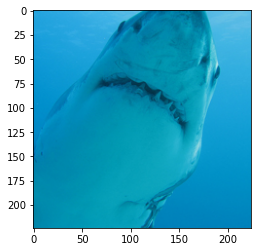

In [227]:
plt.imshow(show_img(img[122]))